In [1065]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
# Preprocesado y modelado
# ==============================================================================
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from google.colab import files

In [1066]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#Entrenamiento


## Hiper-parámetros


* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

**xgboost en python**

import xgboost as xgb

**read in data**

dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

**specify parameters via map**

param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

**make prediction**
preds = bst.predict(dtest)

## Importando DF y observando datos

In [1067]:
DataFrame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Archivos para leer /Tp2/Train_TP2_Datos_2020-2C.csv')

In [1068]:
DataFrame.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [1069]:
DataFrame.shape

(16947, 52)

## 

In [1070]:
DataFrame['Delivery_Year'].value_counts()

2017    6318
2018    5830
2016    4371
2019     414
2020      14
Name: Delivery_Year, dtype: int64

In [1071]:
DataFrame[['Delivery_Year', 'Delivery_Quarter']][DataFrame['Delivery_Year'] == 2018]['Delivery_Quarter'].value_counts()

Q2    1582
Q4    1435
Q1    1431
Q3    1382
Name: Delivery_Quarter, dtype: int64

## **Conversion a dolar y promedio de valores**

(Fijarse si aplicar  conversion de log a los valores porque hay muchos altos y muchos bajos, hay gran dif) y (esto hay que hacerlo dsp de filtrar porque estamos usando datos que a lo mejor ni nos pintan )

In [1072]:
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame['Total_Amount']*0.0096
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame['Total_Amount']*1.17
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame['Total_Amount']*0.70
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame['Total_Amount']*1.29
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [1073]:
DataFrame['Total_Amount'].value_counts()

5.952000e+01    513
4.224000e+01    460
1.728000e+02    351
1.344000e+03    272
1.536000e+01    204
               ... 
1.075200e+04      1
6.869055e+05      1
3.163680e+04      1
1.373772e+06      1
1.749888e+06      1
Name: Total_Amount, Length: 9350, dtype: int64

In [1074]:
DataFrame['Total_Amount'].mean()

1007398.2109417549

## Filtrando por datos que voy a usar

In [1075]:
DataFrame_short = DataFrame[['Region', 'Total_Amount', 'Delivery_Year', 'Delivery_Quarter','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr','Stage' ]].rename(columns={'Stage': 'Decision'})
DataFrame_short = DataFrame_short[(DataFrame_short['Decision'] == 'Closed Lost') | (DataFrame_short['Decision'] == 'Closed Won')]
DataFrame_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
0,EMEA,6169176.0,2016,Q2,1,1,Closed Lost
1,EMEA,56429.1,2016,Q1,0,0,Closed Won
2,Americas,83865.6,2016,Q1,0,0,Closed Won
3,Americas,7421881.5,2018,Q1,0,1,Closed Lost
4,Americas,13357192.5,2018,Q1,0,1,Closed Lost


## Codificación de variables 

**Poner 1 en aquellos que sean >= que 1007398.2109417549 y 0 en aquellos que sean menores que tal monto** (A HACER)


**Hacer en binario los cuarter o va, ponerlos directamente en numero (1 2 3 o 4)**  **hecho, q4 == 1, q1,2,3 = 0**

**Closed lost y won ponerlos en 0 y 1 respectivamente** . **Hecho**

**Hacer en binario las regiones** (A HACER)

In [1076]:
DataFrame_short['Decision'].value_counts()

Closed Won     9533
Closed Lost    7350
Name: Decision, dtype: int64

In [1077]:
DataFrame_short['Decision'] = np.where(DataFrame_short['Decision'] == 'Closed Won',1,0)

In [1078]:
DataFrame_short['Decision'].value_counts()

1    9533
0    7350
Name: Decision, dtype: int64

**Aca flasheo la de Gardel y te clavo 1 en q4 y 0 en los otros**

In [1079]:
DataFrame_short['Delivery_Quarter'] = np.where(DataFrame_short['Delivery_Quarter'] == 'Q4',1,0)

In [1080]:
DataFrame_short['Delivery_Quarter'].value_counts()

0    12749
1     4134
Name: Delivery_Quarter, dtype: int64

**Flasheando de nuevo, ahora para simplificar le clavo el promedio a las regiones asi no hago binary encoding y toda esa wea**

In [1081]:
DataFrame_short['Region'].value_counts()

Japan          4869
EMEA           4660
Americas       3933
APAC           3251
Middle East     170
Name: Region, dtype: int64

In [1082]:
DataFrame_short['Region'] = DataFrame_short.groupby('Region')['Region'].transform('count')

In [1083]:
DataFrame_short['Region'].value_counts()

4869    4869
4660    4660
3933    3933
3251    3251
170      170
Name: Region, dtype: int64

In [1084]:
DataFrame_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
0,4660,6169176.0,2016,0,1,1,0
1,4660,56429.1,2016,0,0,0,1
2,3933,83865.6,2016,0,0,0,1
3,3933,7421881.5,2018,0,0,1,0
4,3933,13357192.5,2018,0,0,1,0


##Plot de los distintos tipos de transformación de features en total amount
**Todo esto fue agregado el 12/2**

In [1085]:
DataFrame_short['Total_Amount'].mean()

1007488.1868518399

In [1086]:
DataFrame_short['Total_Amount'].describe()

count    1.682400e+04
mean     1.007488e+06
std      5.864363e+06
min      0.000000e+00
25%      4.492800e+03
50%      7.673400e+04
75%      2.887052e+05
max      3.150001e+08
Name: Total_Amount, dtype: float64

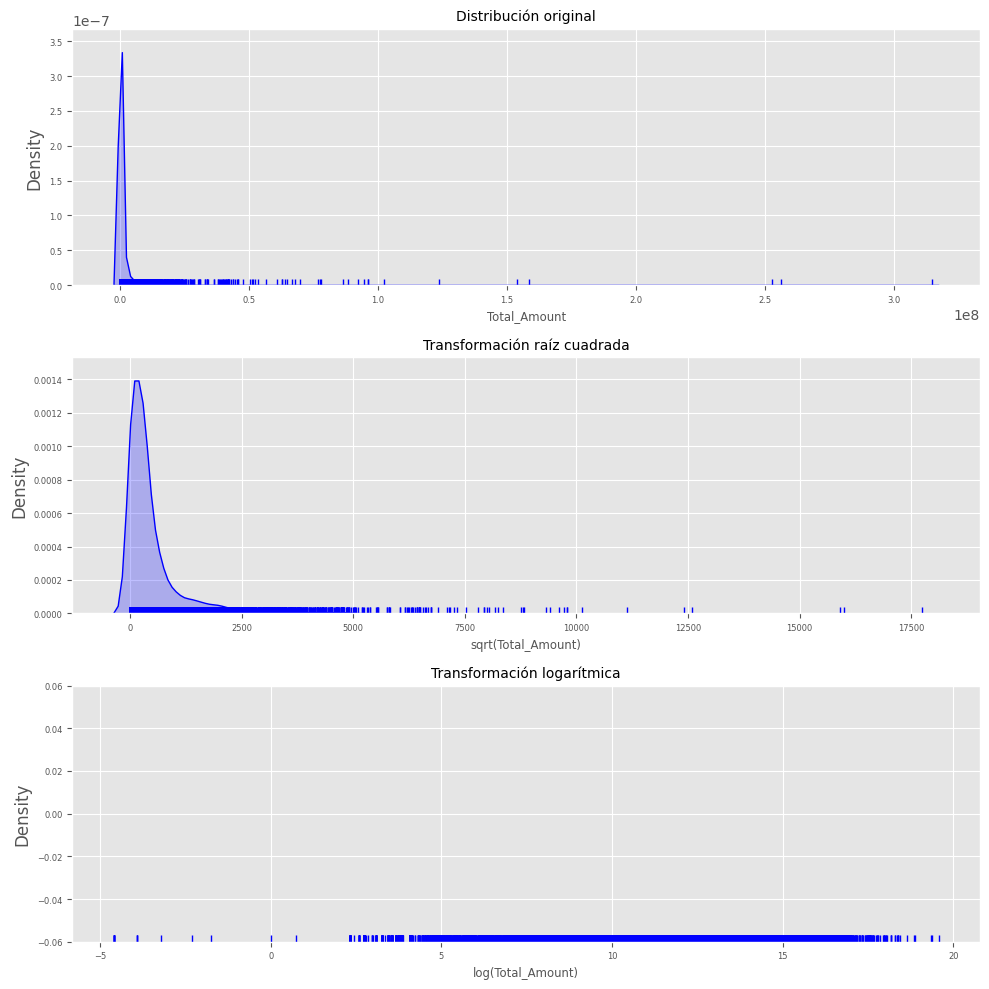

In [1087]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
sns.distplot(
    DataFrame_short.Total_Amount,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Total_Amount', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(DataFrame_short.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Total_Amount)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(DataFrame_short.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Total_Amount)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

Raíz cuadrada parece la mas interesante en este caso

In [1088]:
DataFrame_short['Total_Amount'].describe()

count    1.682400e+04
mean     1.007488e+06
std      5.864363e+06
min      0.000000e+00
25%      4.492800e+03
50%      7.673400e+04
75%      2.887052e+05
max      3.150001e+08
Name: Total_Amount, dtype: float64

In [1089]:
DataFrame_short['Total_Amount'] = np.sqrt(DataFrame_short.Total_Amount)

In [1090]:
DataFrame_short['Total_Amount'].describe()

count    16824.000000
mean       513.982732
std        862.179867
min          0.000000
25%         67.028352
50%        277.009025
75%        537.312918
max      17748.241657
Name: Total_Amount, dtype: float64

In [1091]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas

#fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
#axes = axes.flat
#columnas_numeric = DataFrame_short.select_dtypes(include=['float64', 'int']).columns
#columnas_numeric = columnas_numeric.drop('Total_Amount')

#for i, colum in enumerate(columnas_numeric):
#    sns.histplot(
#        data    = DataFrame_short,
#        x       = colum,
#        stat    = "count",
#        kde     = True,
#        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
#        line_kws= {'linewidth': 2},
#        alpha   = 0.3,
#        ax      = axes[i]
#    )
#    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
#    axes[i].tick_params(labelsize = 6)
#    axes[i].set_xlabel("")
    
    
#fig.tight_layout()
#plt.subplots_adjust(top = 0.9)
#fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");


## Separación de entrenamiento y Test

In [1092]:
Entrenamiento = DataFrame_short.loc[:,DataFrame_short.columns != 'Decision']

In [1093]:
Entrenamiento

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
0,4660,2483.782599,2016,0,1,1
1,4660,237.548100,2016,0,0,0
2,3933,289.595580,2016,0,0,0
3,3933,2724.313033,2018,0,0,1
4,3933,3654.749307,2018,0,0,1
...,...,...,...,...,...,...
16942,4660,347.734813,2016,0,1,1
16943,4660,329.890209,2016,0,1,1
16944,4660,347.734813,2016,0,1,1
16945,3933,1531.925873,2016,0,1,1


In [1094]:
#Test = DataFrame_short[(DataFrame_short['Delivery_Year']== 2018) & (DataFrame_short['Delivery_Quarter'] == 1)]
#Test = Test['Decision']
#Test

In [1095]:
Test = DataFrame_short.loc[:,'Decision']


In [1096]:
Entrenamiento.shape, Test.shape, DataFrame_short.shape

((16883, 6), (16883,), (16883, 7))

##Entrenamiento y Test

Para poder entrenar X e Y tengo que tener la misma cant de filas XD

In [1097]:
X_Entrenamiento, X_EntrenamientoTest, Y_TestEntrenamiento, Y_TestTest = train_test_split(Entrenamiento,Test,test_size = 0.2, random_state = 0)

In [1098]:
X_Entrenamiento.shape, X_EntrenamientoTest.shape, Y_TestEntrenamiento.shape, Y_TestTest.shape

((13506, 6), (3377, 6), (13506,), (3377,))

In [1099]:
xg_clas = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.001, max_depth = 10, alpha = 10, n_estimators = 200)

In [1100]:
xg_clas.fit(X_Entrenamiento,Y_TestEntrenamiento)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [1101]:
preds = xg_clas.predict(X_EntrenamientoTest)

In [1102]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_TestTest, preds))
print(classification_report(Y_TestTest, preds))
pd.crosstab(Y_TestTest, preds)

0.7678412792419307
              precision    recall  f1-score   support

           0       0.80      0.65      0.72      1524
           1       0.75      0.86      0.80      1853

    accuracy                           0.77      3377
   macro avg       0.77      0.76      0.76      3377
weighted avg       0.77      0.77      0.76      3377



col_0,0,1
Decision,,
0,995,529
1,255,1598


In [1103]:
value_pred = pd.DataFrame()
value_pred['pred'] = preds
value_pred['pred'].value_counts()

1    2127
0    1250
Name: pred, dtype: int64

In [1104]:
rmse = np.sqrt(mean_squared_error(Y_TestTest, preds))
print("RMSE: %f" % (rmse))
accuracy = accuracy_score(Y_TestTest, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

RMSE: 0.481829
Accuracy: 76.78%


learning rate 0.1 57%   |||||  n_estimators 10

""            0.05 56%   ||        ""

""            0.5 60%     |||       ""

In [1105]:
#acc = accuracy_score(X_Entrenamiento, Y_TestEntrenamiento)

In [1106]:
#from sklearn.metrics import accuracy_score
#accuracy = accuracy_score(Y_Test, preds)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Importancia de los features
Le paso una wea ya entrenada 

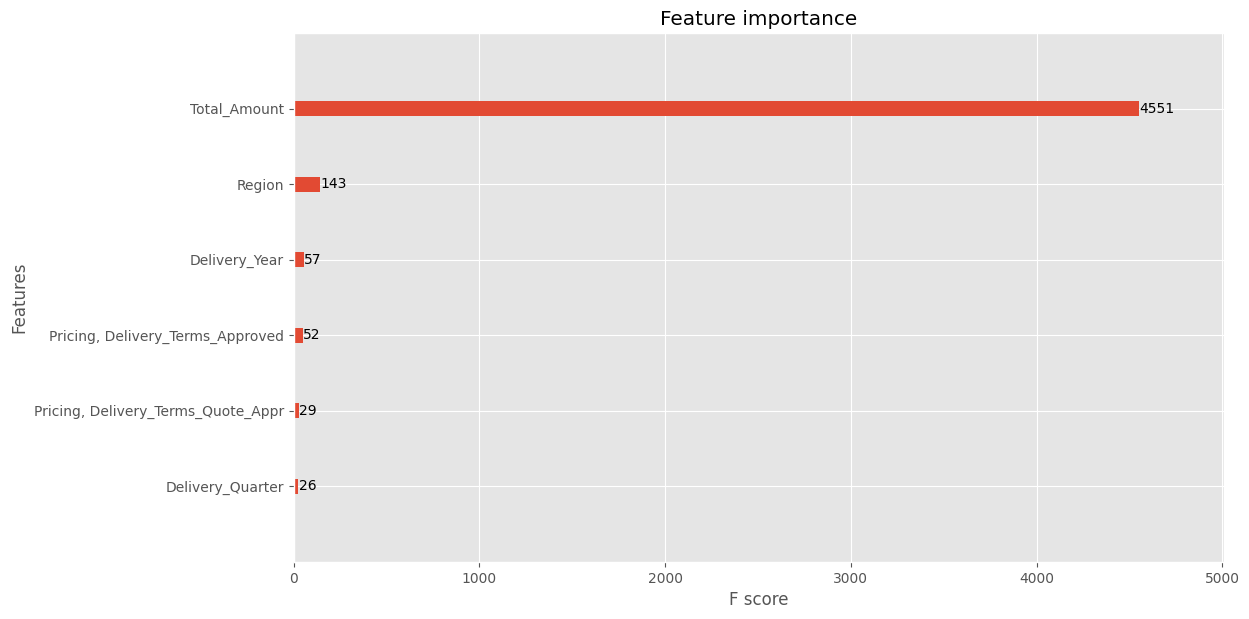

In [1107]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_clas)

##Visualizacion del arbol

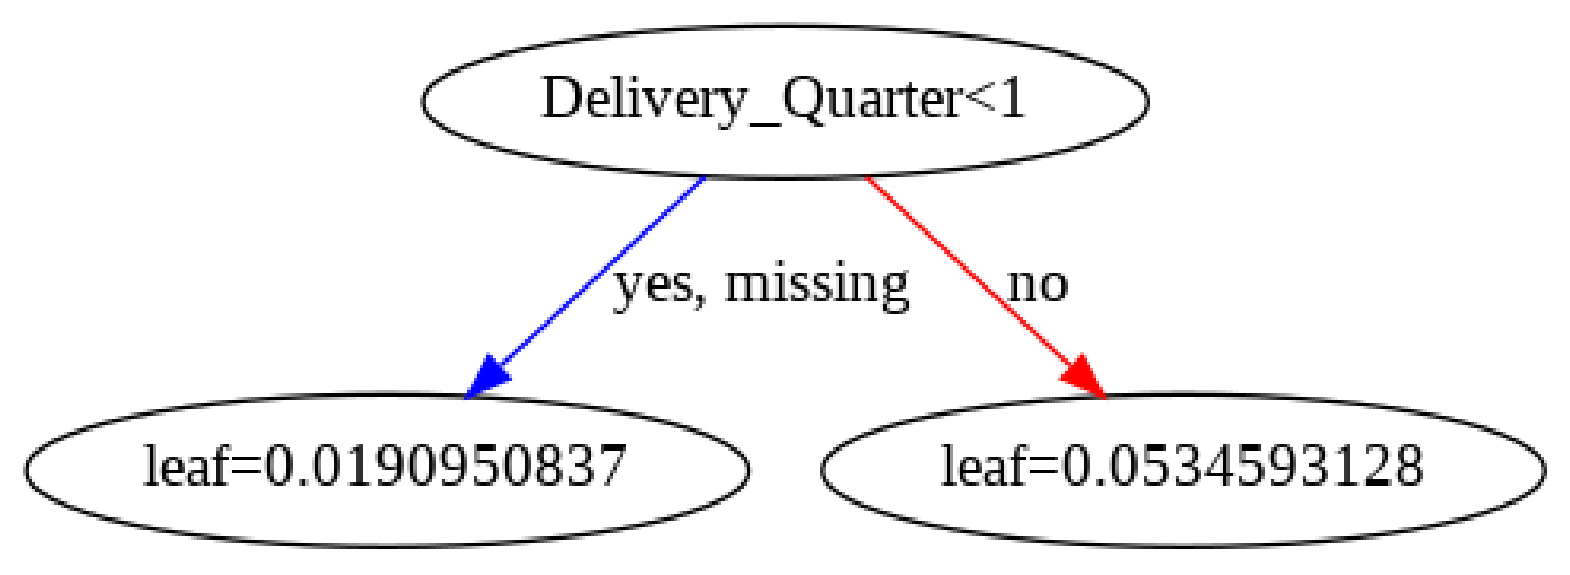

In [1108]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_clas, num_trees = 0)

#Test

##DF

In [1109]:
DataFrame_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Archivos para leer /Tp2/Test_TP2_Datos_2020-2C.csv')

In [1110]:
DataFrame_test.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_140,Product_Name_241,EUR,0.275,USD,0.31105,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,6/1/2019,6/28/2019,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,6/1/2019,6/29/2019,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None


In [1111]:
DataFrame_test.shape

(2551, 51)

In [1112]:
DataFrame_test['Opportunity_ID'].value_counts()

12266    26
10973    24
11089    18
11869    15
11248    11
         ..
11778     1
12181     1
12179     1
11518     1
11488     1
Name: Opportunity_ID, Length: 1567, dtype: int64

##Conversion y filtra3


In [1113]:
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.0096
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.17
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.70
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.29
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [1114]:
DataFrame_test_short = DataFrame_test[['Region', 'Total_Amount', 'Delivery_Year', 'Delivery_Quarter','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr']].rename(columns={'Stage': 'Decision'})
DataFrame_test_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
0,EMEA,189820.80,2019,Q2,1,1
1,EMEA,91990.08,2019,Q2,1,1
2,EMEA,148069.35,2019,Q2,1,1
3,EMEA,284731.20,2019,Q2,1,1
4,EMEA,183980.16,2019,Q2,1,1


In [1115]:
DataFrame_test_short['Delivery_Quarter'] = np.where(DataFrame_test_short['Delivery_Quarter'] == 'Q4',1,0)

In [1116]:
DataFrame_test_short['Region'] = DataFrame_test_short.groupby('Region')['Region'].transform('count')

In [1117]:
DataFrame_test_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
0,838,189820.80,2019,0,1,1
1,838,91990.08,2019,0,1,1
2,838,148069.35,2019,0,1,1
3,838,284731.20,2019,0,1,1
4,838,183980.16,2019,0,1,1


Agregue raiz cuadrada 12/2

In [1118]:
DataFrame_test_short['Total_Amount'] = np.sqrt(DataFrame_test_short.Total_Amount)

In [1119]:
pred_posta = xg_clas.predict(DataFrame_test_short)

In [1120]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test['Opportunity_ID']
subir['target'] = pred_posta
subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

,target
Opportunity_ID,
10689,0
10690,0
10691,1
10692,0
10693,0
...,...
12364,0
12365,0
12366,0


In [1121]:
subir['target'].value_counts()

0    1556
1      11
Name: target, dtype: int64

In [1122]:
csv3 = subir.to_csv('xgboost_pred_1.csv')
#files.download('xgboost_pred_1.csv')

#Probando otra forma


##Entrenamiento y test

In [1123]:
#xgb= XGBClassifier()

In [1124]:
#parameters = {'nthreads' : [1], 'objective' : ['binary:logistic'], 'learning_rate' : [0.05, 0.1], 'n_estimators' : [100, 200]}

In [1125]:
#fit_params = {'early_stopping_round' : 10, 'eval_metric' : 'logloss', 'eval_set' : [(X_Entrenamiento,Y_TestEntrenamiento)]}

In [1126]:
#clf = GridSearchCV(xgb, parameters, cv = 3, scoring = 'accuracy')
#clf.fit(X_Entrenamiento,Y_TestEntrenamiento, **fit_params)

In [1127]:
#